# Final Project Submission

Student Name: Asad Rahman

Student Pace: Full Time

Scheduled Project Review Date/Time: Thur May 16, 2019 - 1pm

Instructor Name: Victor Geislinger

## Objective:

"The goal of your project is to query the database to get the data needed to perform a statistical analysis. In this statistical analysis, you'll need to perform a hypothesis test (or perhaps several) to answer the following question:

**Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?**

In addition to answering this question with a hypothesis test, you will also need to **come up with at least 3 other hypotheses to test on your own**. These can by anything that you think could be imporant information for the company.

For this hypothesis, be sure to specify both the null hypothesis and the alternative hypothesis for your question. You should also specify if this is one-tail or a two-tail test."

### Database:

For this project, you'll be working with the Northwind database--a free, open-source dataset created by Microsoft containing data from a fictional company. You probably remember the Northwind database from our section on Advanced SQL. Here's the schema for the Northwind database:

<img src='Northwind_ERD.png'>

### Question 1: Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

Using SQLAlchemy, we will be importing data from the database provided so we can further explore it.

In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
# Create an engine and connecting to a database with SQLAlchemy
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

2019-05-16 11:17:37,665 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-16 11:17:37,670 INFO sqlalchemy.engine.base.Engine ()
2019-05-16 11:17:37,672 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-16 11:17:37,673 INFO sqlalchemy.engine.base.Engine ()


In [3]:
# Getting the table names
inspector = inspect(engine)
inspector.get_table_names()

2019-05-16 11:17:37,694 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-16 11:17:37,696 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

We now want to extract the quanitity of products ordered and the discount level for each order from the OrderDetail table

In [4]:
# extracting the dataset as a pd.dataframe
question1 = pd.read_sql_query("""SELECT Quantity, Discount FROM OrderDetail""", engine)
question1.head()

2019-05-16 11:17:37,725 INFO sqlalchemy.engine.base.Engine SELECT Quantity, Discount FROM OrderDetail
2019-05-16 11:17:37,726 INFO sqlalchemy.engine.base.Engine ()


,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [5]:
question1.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [6]:
(8/len(question1))*100

0.37122969837587005

In [7]:
#Dropping discount levels .01,.02,.03,.04, and .06
question1 = question1[question1.Discount.isin(["0.00","0.05","0.10","0.15","0.20","0.25"])]

In [8]:
#Creating a column for discounted/not discounted
question1["is_discounted"] = question1["Discount"].apply(lambda x: 1 if x > 0 else 0)

In [9]:
display(question1.head())
print(question1.info())

,Quantity,Discount,is_discounted
0,12,0.0,0
1,10,0.0,0
2,5,0.0,0
3,9,0.0,0
4,40,0.0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2154
Data columns (total 3 columns):
Quantity         2147 non-null int64
Discount         2147 non-null float64
is_discounted    2147 non-null int64
dtypes: float64(1), int64(2)
memory usage: 67.1 KB
None


Exploring the data reveals all the orders fall under discount levels between 0 - 25%, most of them being at the 5% increments. Due to the rest of the orders (discounted at levels .01,.02,.03,.04, and .06) represent less than .4% of all orders, we opted to drop these orders in our testing.

We also created another column for whether or not an order is discounted (1) or not (0)

"Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?"

To begin we'll define out Null and Alternative Hypothesis:

H<sub>0</sub>: The average number of discounted products ordered is equal to the number of non discounted products ordered

H<sub>a</sub>: The average number of discounted products ordered is greater or less than the number of non discounted products ordered

With an alpha significance level of .05.

In [10]:
#compare the amount of orders sold by "is_discounted"
print("Total Orders:")
print(question1.groupby(["is_discounted"])["Quantity"].count())

Total Orders:
is_discounted
0    1317
1     830
Name: Quantity, dtype: int64


In [11]:
#compare the average number of orders sold by "is_discounted"
print("Average:")
print(question1.groupby(["is_discounted"])["Quantity"].mean())

Average:
is_discounted
0    21.715262
1    27.354217
Name: Quantity, dtype: float64


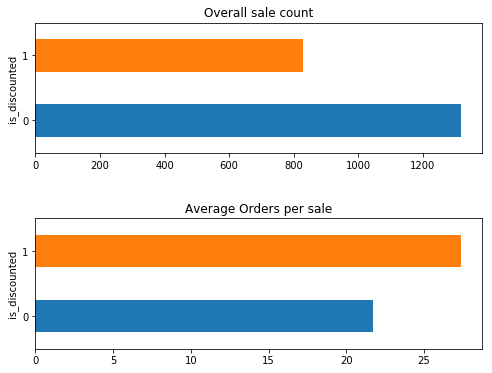

In [12]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,6))
question1.groupby(["is_discounted"])["Quantity"].count().plot(kind="barh", ax=ax1)
question1.groupby(["is_discounted"])["Quantity"].mean().plot(kind="barh", ax=ax2)
ax1.set_title("Overall sale count")
ax2.set_title("Average Orders per sale")
fig.subplots_adjust(hspace=0.5)

Although initially it seems that there are more non-discounted orders overall, a check of the average number of units ordered per sale shows that to be untrue. This seems to be supporting our alternative hypothesis. Using a two-tailed t-test, due to the hypothesis searching for a change in products ordered (in either a positive or negative way).

C:\Users\Asad\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


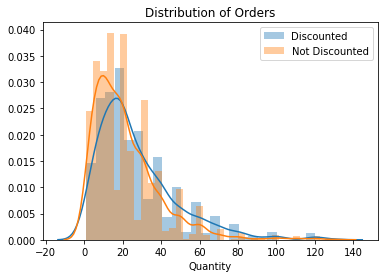

In [13]:
#check the distribution of the discounted/non-discounted data for normality
discount=question1[question1["is_discounted"] == 1]
no_discount=question1[question1["is_discounted"] == 0]
sns.distplot(discount.Quantity, label="Discounted")
sns.distplot(no_discount.Quantity, label="Not Discounted")
plt.title("Distribution of Orders")
plt.legend()

Two-sample t-tests assumes normally distributed data which seems true in our distribution plot, although there is a positive skew. Considering our assumptions to be true we can proceed with a standard t test.

In [14]:
stats.ttest_ind(discount.Quantity, no_discount.Quantity)

Ttest_indResult(statistic=6.7627297036707565, pvalue=1.7401995278127614e-11)

With a P value of <0.001, and an alpha value of 0.05, we can reject the null hypothesis. Thus, the alternative hypothesis of there being a statistically significant difference between the average number of discounted products ordered compared to nondiscounted orders is true.

"If so, at what level(s) of discount?"

Now we must distinguish whether each discount level is significant from eachother, so again we'll establish a null and alternative hypothesis:

H<sub>0</sub>: The average number of products ordered is the same at all levels of discount

H<sub>a</sub>: The average number of products ordered is different at different discount levels

Again we will be working under an alpha level of 0.05

In [15]:
#ANOVA table created to fit total quantity between discount levels
lm = ols("Quantity ~ C(Discount)", discount).fit()
display(sm.stats.anova_lm(lm, typ=2))

display(lm.summary())

,sum_sq,df,F,PR(>F)
C(Discount),1159.517551,4.0,0.674103,0.610041
Residual,354768.342690,825.0,NaN,NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6741
Date:                Thu, 16 May 2019   Prob (F-statistic):              0.610
Time:                        11:17:38   Log-Likelihood:                -3691.7
No. Observations:                 830   AIC:                             7393.
Df Residuals:                     825   BIC:                             7417.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              28.0108      1.525     18.372      0.000      25.018      31.003
C(Discount)[T.0.1]     -2.7738      2.193     -1.265      0.206      -7.079       1.531
C(Discount)[T.0.15]     0.3714      2.250      0.165      0.869      -4.045       4.788
C(Discount)[T.0.2]     -0.9860      2.235     -0.441      0.659      -5.373       3.401
C(Discount)[T.0.25]     0.2294      2.262      0.101      0.919      -4.211       4.669
==============================================================================
Omnibus:                      263.705   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              751.622
Skew:                           1.598   Prob(JB):                    6.13e-164
Kurtosis:                       6.394   Cond. No.                         5.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

An ANOVA table was used to assess the degree of variation between the different levels of discount. We attained a p-value of .610, greater than our alpha value of 0.05, which means we have failed to reject our null hypothesis. The model summary also confirms this showing each instances p-value are also above the alpha level, thus confirming there is no statistical difference between average orders made between each discount level.

###### Answer:
    While discounts do have a statistically significant effect on the number of products customers order, there is no distinction between the amount of a discount applied that has this effect.

### Question 2: Is the company seeing a difference in sale revenue between discounted and nondiscounted orders?

We initially observed there is an increase in customer orders due to the fact that that order was discounted. When a product is discounted, there is a perceived loss in profit. We'll further our exploration by asking if the company is recuperating the money lost by discounts through increased sales.

In [16]:
# extracting dataset as a pd.dataframe
question2 = pd.read_sql_query("""SELECT Quantity, UnitPrice, Discount FROM OrderDetail""",engine)
question2.head()

2019-05-16 11:17:38,908 INFO sqlalchemy.engine.base.Engine SELECT Quantity, UnitPrice, Discount FROM OrderDetail
2019-05-16 11:17:38,910 INFO sqlalchemy.engine.base.Engine ()


,Quantity,UnitPrice,Discount
0,12,14.0,0.0
1,10,9.8,0.0
2,5,34.8,0.0
3,9,18.6,0.0
4,40,42.4,0.0


In [17]:
question2.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [18]:
question2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 3 columns):
Quantity     2155 non-null int64
UnitPrice    2155 non-null float64
Discount     2155 non-null float64
dtypes: float64(2), int64(1)
memory usage: 50.6 KB


We'll also add columns for is_discounted and total order price

In [19]:
#Creating a column for discounted/not discounted
question2["is_discounted"] = question2["Discount"].apply(lambda x: 1 if x > 0 else 0)
#creating a column for total order price
question2["total_order_price"] = question2.Quantity * question2.UnitPrice * (1- question2.Discount)
#drop the unitprice,quantity, and specific levels of discounts
question2.drop(["UnitPrice","Discount"],axis=1,inplace=True)

In [20]:
display(question2.head())
print(question2.info())

,Quantity,is_discounted,total_order_price
0,12,0,168.0
1,10,0,98.0
2,5,0,174.0
3,9,0,167.4
4,40,0,1696.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 3 columns):
Quantity             2155 non-null int64
is_discounted        2155 non-null int64
total_order_price    2155 non-null float64
dtypes: float64(1), int64(2)
memory usage: 50.6 KB
None


"Is the company seeing increased revenue through increased number of sales, even though the products are discounted?"

To begin we'll define our Null and Alternative Hypothesis:

H<sub>0</sub>: There is no difference in revenue gained between discounted and nondiscounted orders

H<sub>a</sub>: There is a difference in revenue gained for discounted orders, compared to nondiscounted orders

With an alpha significance level of .05.

In [21]:
#compare the average number of orders sold by "is_discounted"
print("Average:")
print(question2.groupby(["is_discounted"])["total_order_price"].mean())

Average:
is_discounted
0    570.006538
1    614.671157
Name: total_order_price, dtype: float64


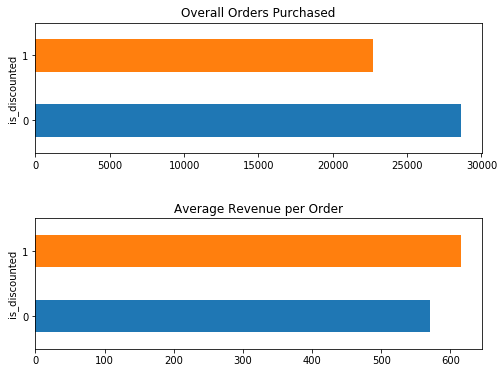

In [43]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,6))
question2.groupby(["is_discounted"])["Quantity"].sum().plot(kind="barh", ax=ax1)
question2.groupby(["is_discounted"])["total_order_price"].mean().plot(kind="barh", ax=ax2)
ax1.set_title("Overall Orders Purchased")
ax2.set_title("Average Revenue per Order")
fig.subplots_adjust(hspace=0.5)

Although overall orders purchased show a greater amount being non discounted, the average revenue per order is greater when the product is discounted. We can further test this relationship through a two sample t-test, assuming normality.

C:\Users\Asad\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


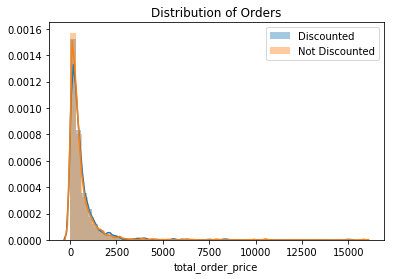

In [23]:
#check the distribution of the discounted/non-discounted data for normality
discount=question2[question2["is_discounted"] == 1]
no_discount=question2[question2["is_discounted"] == 0]
sns.distplot(discount.total_order_price, label="Discounted")
sns.distplot(no_discount.total_order_price, label="Not Discounted")
plt.title("Distribution of Orders")
plt.legend()

Although normalization is often assumed with sample sizes greater than 30, we logarithmically transformaed that data for a more gaussian distribution

In [24]:
#log-transforming total_order_price
question2_log = question2.copy()
question2_log["total_order_price"] = np.log(question2_log["total_order_price"])

C:\Users\Asad\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


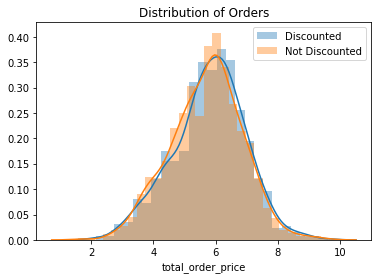

In [25]:
#recheck the distribution of the discounted/non-discounted data for normality
discount_log=question2_log[question2_log["is_discounted"] == 1]
no_discount_log=question2_log[question2_log["is_discounted"] == 0]
sns.distplot(discount_log.total_order_price, label="Discounted")
sns.distplot(no_discount_log.total_order_price, label="Not Discounted")
plt.title("Distribution of Orders")
plt.legend()

In [26]:
#running a two-sided t-test to compare two independent samples
stats.ttest_ind(discount_log.total_order_price, no_discount_log.total_order_price)

Ttest_indResult(statistic=1.6429082152460772, pvalue=0.10054794734142733)

With a P value of ~0.1, and an alpha value of 0.05, we failed to reject the null hypothesis.

###### Answer:
    With the data we have available to us right now, we can say there is no statistically significant difference in revenue by orders, discounted or not.

### Question 3: Do different months see increased or decreased sale trends?

Customer sale trends in relation to monthly sales would help the company further capitalize on beneficial months, if there are any. Our main priority is recognizing the amount of sales and in which months these are made.

In [27]:
# extracing the dataset as a pd.dataframe
question3 = pd.read_sql_query("""SELECT o.OrderDate, od.Quantity FROM [Order] o JOIN OrderDetail od ON od.OrderID=o.ID""",engine)
question3.head()

2019-05-16 11:17:40,222 INFO sqlalchemy.engine.base.Engine SELECT o.OrderDate, od.Quantity FROM [Order] o JOIN OrderDetail od ON od.OrderID=o.ID
2019-05-16 11:17:40,223 INFO sqlalchemy.engine.base.Engine ()


,OrderDate,Quantity
0,2012-07-04,12
1,2012-07-04,10
2,2012-07-04,5
3,2012-07-05,9
4,2012-07-05,40


In [28]:
#converting orderdate to datetime
question3["OrderDate"]=pd.to_datetime(question3["OrderDate"])
#adding column for int month, for visualizing
question3["Month_int"] = question3["OrderDate"].dt.month
question3.head()

,OrderDate,Quantity,Month_int
0,2012-07-04,12,7
1,2012-07-04,10,7
2,2012-07-04,5,7
3,2012-07-05,9,7
4,2012-07-05,40,7


Text(0, 0.5, 'Month')

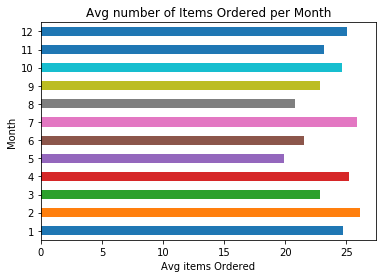

In [29]:
figure = question3.groupby(["Month_int"])["Quantity"].mean().plot(kind="barh")
figure.set_title("Avg number of Items Ordered per Month")
figure.set_xlabel("Avg items Ordered")
figure.set_ylabel("Month")

"Do different months see increased or decreased sale trends?"

To begin we'll define our Null and Alternative Hypothesis:

H<sub>0</sub>: There is no difference in average orders made between months

H<sub>a</sub>: Certain months see an increased or decreased average in orders

With an alpha significance level of .05.

Our graph doesn't distinctly differentiate which month is more beneficial as opposed to any other, which is were a statistical analysis of our data would help. ANOVA testing assumes normal distribution, tested by plotting distribution plots.

C:\Users\Asad\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


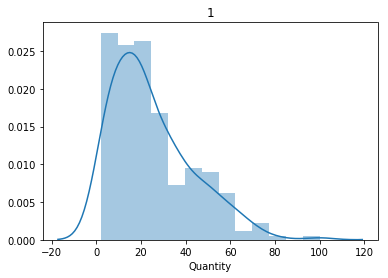

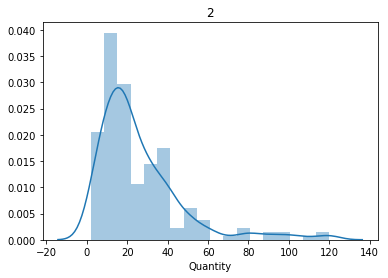

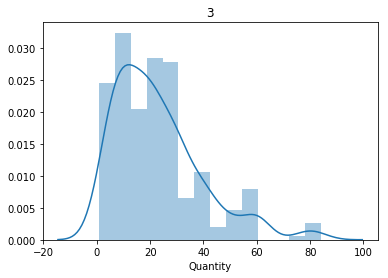

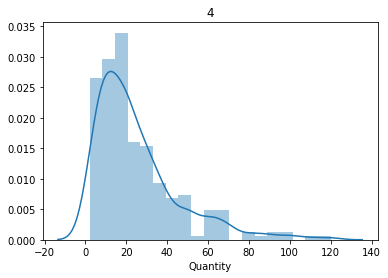

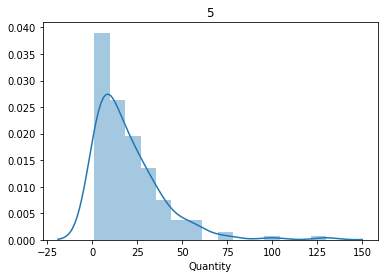

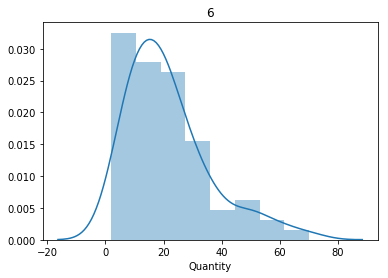

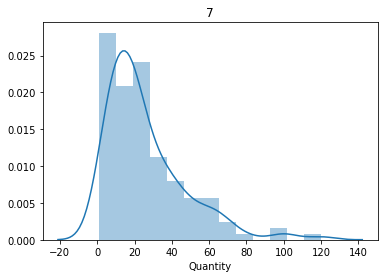

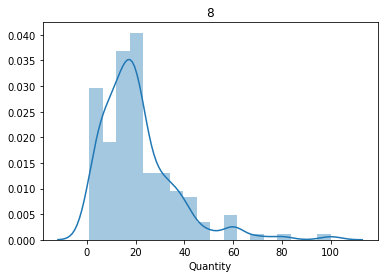

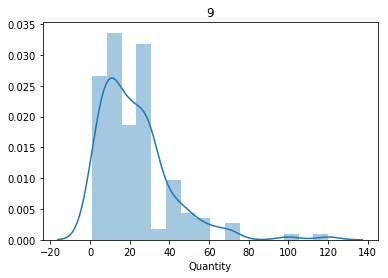

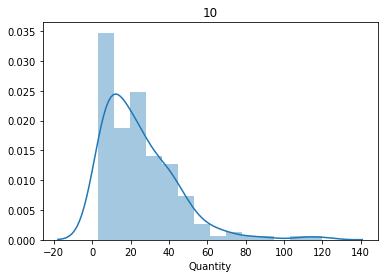

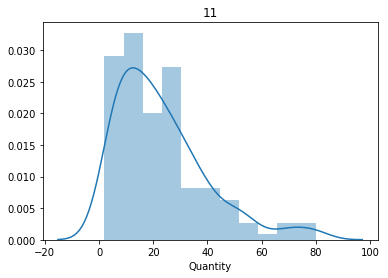

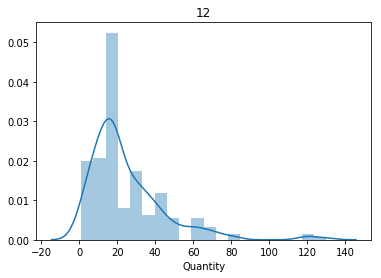

In [30]:
for month in set(question3["Month_int"]):
    month_group = question3.loc[question3["Month_int"] == month]
    sns.distplot(month_group["Quantity"])
    plt.title(month)
    plt.show()

Although some months show some positive skew, we proceed to test our data.

In [31]:
lm = ols("Quantity ~C(Month_int)", question3).fit()
sm.stats.anova_lm(lm,typ=2)

,sum_sq,df,F,PR(>F)
C(Month_int),7395.980026,11.0,1.866405,0.039229
Residual,772003.656168,2143.0,NaN,NaN


In [32]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.866
Date:                Thu, 16 May 2019   Prob (F-statistic):             0.0392
Time:                        11:17:42   Log-Likelihood:                -9394.8
No. Observations:                2155   AIC:                         1.881e+04
Df Residuals:                    2143   BIC:                         1.888e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             24.7553      1.233     20.079      0.000      22.337      27.173
C(Month_int)[T.2]      1.3492      1.820      0.741      0.459      -2.220       4.918
C(Month_int)[T.3]     -1.8729      1.713     -1.094      0.274      -5.231       1.485
C(Month_int)[T.4]      0.5014      1.703      0.294      0.768      -2.838       3.841
C(Month_int)[T.5]     -4.8520      1.961     -2.475      0.013      -8.697      -1.007
C(Month_int)[T.6]     -3.2421      2.502     -1.296      0.195      -8.149       1.665
C(Month_int)[T.7]      1.0977      2.042      0.538      0.591      -2.906       5.102
C(Month_int)[T.8]     -3.9514      1.968     -2.007      0.045      -7.812      -0.091
C(Month_int)[T.9]     -1.9461      1.972     -0.987      0.324      -5.814       1.922
C(Month_int)[T.10]    -0.0793      1.880     -0.042      0.966      -3.765       3.607
C(Month_int)[T.11]    -1.5875      1.961     -0.810      0.418      -5.433       2.257
C(Month_int)[T.12]     0.2806      1.835      0.153      0.878      -3.318       3.879
==============================================================================
Omnibus:                      779.264   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2955.467
Skew:                           1.763   Prob(JB):                         0.00
Kurtosis:                       7.526   Cond. No.                         11.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Although we have a low r squared value, showing our model represents only a portion of the variation of the data, our p value is below 0.05 - showing significance. We can also see certain months have p-values below 0.05 while other do not, another question to be explored on which months show more significance than others. But in this test for now, we reject the null hypothesis and accept the alternative hypothesis.

###### Answer:
    Certain months see an increased or decreased average in orders

### Question 4: Is there a difference in spending per order between regions?

By recognizing different spending patterns in different regions in the world, a company can more intelligently spend its money promoting its products. We decided to evaluate if there is indeed a difference in average spending per order between different regions.

In [33]:
# extract the dataset to a pd.dataframe
question4 = pd.read_sql_query("""SELECT c.Region, od.Quantity, od.UnitPrice, od.Discount
    FROM Customer c
    JOIN [Order] o ON c.Id = o.CustomerId
    JOIN OrderDetail od ON od.OrderId = o.Id""",engine)
question4.head()

2019-05-16 11:17:42,908 INFO sqlalchemy.engine.base.Engine SELECT c.Region, od.Quantity, od.UnitPrice, od.Discount
    FROM Customer c
    JOIN [Order] o ON c.Id = o.CustomerId
    JOIN OrderDetail od ON od.OrderId = o.Id
2019-05-16 11:17:42,910 INFO sqlalchemy.engine.base.Engine ()


,Region,Quantity,UnitPrice,Discount
0,Western Europe,12,14.0,0.0
1,Western Europe,10,9.8,0.0
2,Western Europe,5,34.8,0.0
3,Western Europe,9,18.6,0.0
4,Western Europe,40,42.4,0.0


In [34]:
question4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 4 columns):
Region       2078 non-null object
Quantity     2078 non-null int64
UnitPrice    2078 non-null float64
Discount     2078 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 65.0+ KB


In [35]:
#Create a column for total order price and price per order
question4["total_order_price"] = question4.Quantity * question4.UnitPrice * (1-question4.Discount)
question4["price_per_order"] = question4.total_order_price / question4.Quantity
#drop the discount column
question4.drop(["UnitPrice","Discount"], axis=1, inplace=True)

In [36]:
question4.head()

,Region,Quantity,total_order_price,price_per_order
0,Western Europe,12,168.0,14.0
1,Western Europe,10,98.0,9.8
2,Western Europe,5,174.0,34.8
3,Western Europe,9,167.4,18.6
4,Western Europe,40,1696.0,42.4


We created a table including the different regions that this company caters, how many products are being sold per order, the total price of the order and on average how much this comes out to in dollars per order. With this information, we can attempt to answer our question.

"Is there a difference in spending between regions?"

To begin we'll define our Null and Alternative Hypothesis:

H0: There is no difference in how much different regions spends on average per orders

Ha: There is a difference in spending between regions

With an alpha significance level of .05.

In [37]:
#group the data by region
question4top = question4.groupby(["Region"])["total_order_price"].sum().reset_index()
question4ppo = question4.groupby(["Region"])["price_per_order"].mean().reset_index()
display(question4top)
display(question4ppo)

,Region,total_order_price
0,British Isles,108951.2150
1,Central America,16558.1000
2,Eastern Europe,3531.9500
3,North America,295780.9005
4,Northern Europe,87156.1625
5,Scandinavia,24545.2025
6,South America,142677.8080
7,Southern Europe,45225.7175
8,Western Europe,503548.4085


,Region,price_per_order
0,British Isles,24.056868
1,Central America,26.359091
2,Eastern Europe,20.631250
3,North America,27.283874
4,Northern Europe,23.909930
5,Scandinavia,26.828964
6,South America,23.288849
7,Southern Europe,21.684325
8,Western Europe,24.868188


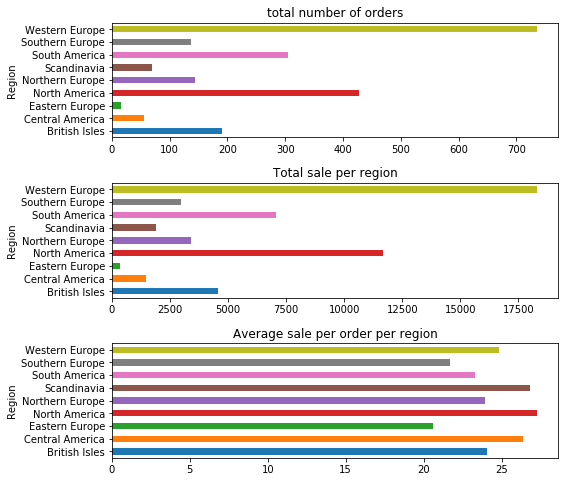

In [38]:
#plotting the orders, revenue, and average sale per order
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (8,8))
question4.groupby(["Region"])["Region"].count().plot(kind="barh", ax=ax1)
question4.groupby(["Region"])["price_per_order"].sum().plot(kind="barh", ax=ax2)
question4.groupby(["Region"])["price_per_order"].mean().plot(kind="barh", ax=ax3)
ax1.set_title("total number of orders")
ax2.set_title("Total sale per region")
ax3.set_title("Average sale per order per region")
fig.subplots_adjust(hspace=.4)

Although we can recognize a huge variation in sales orders, Western Europe being a major spender, the average sale per order is similiar regardless of region. We'll further investigate this through our ANOVA analysis.

C:\Users\Asad\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


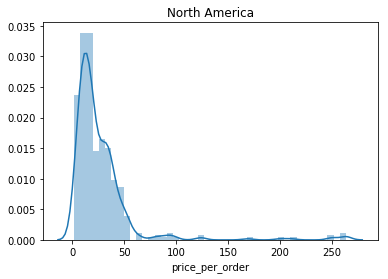

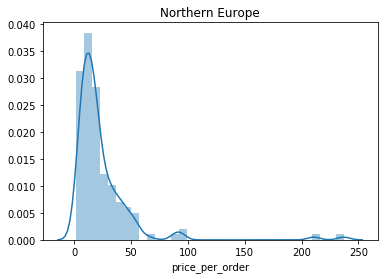

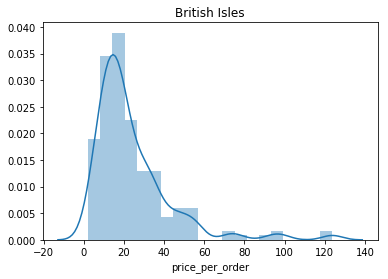

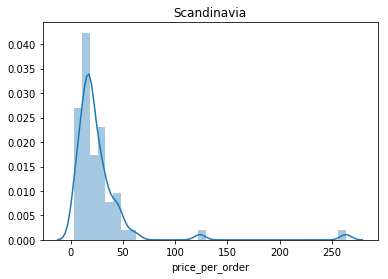

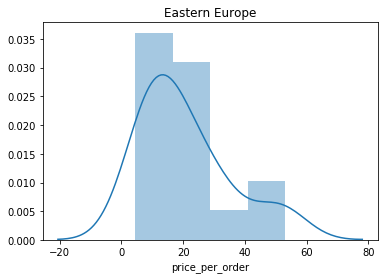

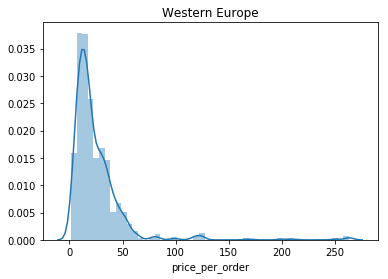

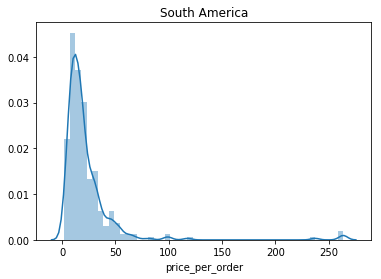

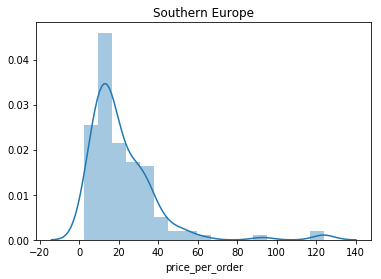

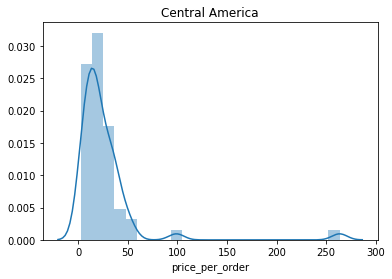

In [39]:
#seperate the data by region, assessing distribution
for region in set(question4.Region):
    region_group = question4.loc[question4["Region"] == region]
    sns.distplot(region_group["price_per_order"])
    plt.title(region)
    plt.show()

Most of our regions showed positive, non-normal distributions. In this case, log-transforming the data will make better assumptions

In [40]:
question4_log = question4.copy()
question4_log["price_per_order"] = np.log(question4["price_per_order"])

C:\Users\Asad\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


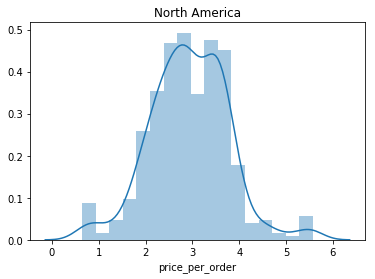

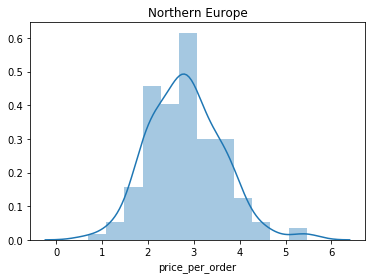

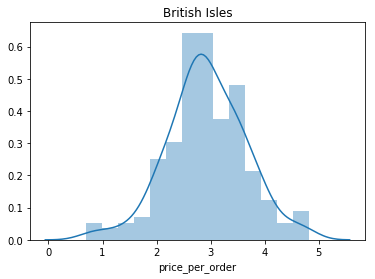

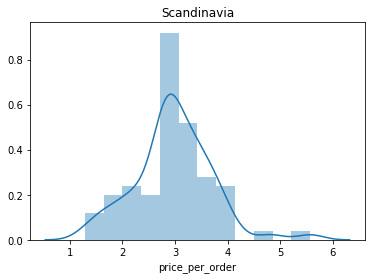

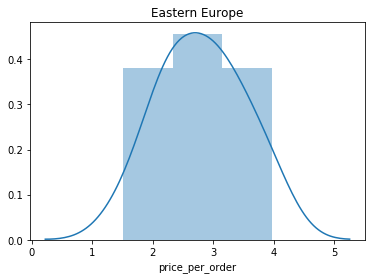

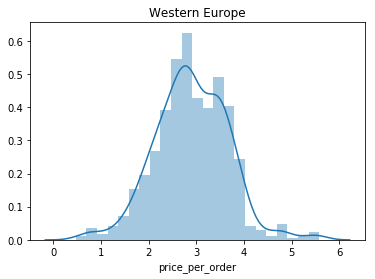

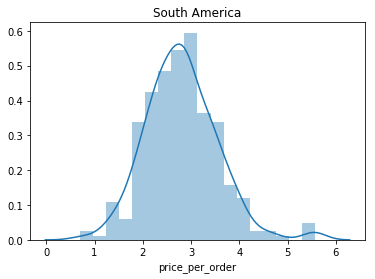

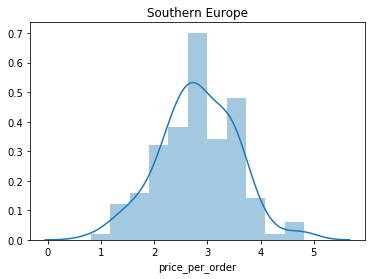

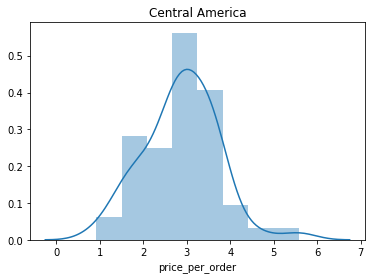

In [41]:
#Replotting to assess normality
for region in set(question4_log.Region):
    region_group = question4_log.loc[question4_log["Region"] == region]
    sns.distplot(region_group["price_per_order"])
    plt.title(region)
    plt.show()

In [42]:
#Fit the model of pricer_per_order on region categories using an ANOVA table
lm = ols("price_per_order ~ C(Region)", question4_log).fit()
display(sm.stats.anova_lm(lm, typ=2))

display(lm.summary())

,sum_sq,df,F,PR(>F)
C(Region),5.174296,8.0,1.08195,0.372671
Residual,1236.843194,2069.0,NaN,NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_order   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.082
Date:                Thu, 16 May 2019   Prob (F-statistic):              0.373
Time:                        11:17:46   Log-Likelihood:                -2409.5
No. Observations:                2078   AIC:                             4837.
Df Residuals:                    2069   BIC:                             4888.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        2.9205      0.056     52.066      0.000       2.810       3.030
C(Region)[T.Central America]    -0.0500      0.118     -0.422      0.673      -0.282       0.182
C(Region)[T.Eastern Europe]     -0.1195      0.201     -0.594      0.553      -0.514       0.275
C(Region)[T.North America]       0.0136      0.067      0.202      0.840      -0.119       0.146
C(Region)[T.Northern Europe]    -0.1004      0.086     -1.173      0.241      -0.268       0.068
C(Region)[T.Scandinavia]         0.0503      0.108      0.465      0.642      -0.162       0.262
C(Region)[T.South America]      -0.1145      0.072     -1.601      0.110      -0.255       0.026
C(Region)[T.Southern Europe]    -0.1013      0.087     -1.169      0.243      -0.271       0.069
C(Region)[T.Western Europe]     -0.0201      0.063     -0.320      0.749      -0.144       0.103
==============================================================================
Omnibus:                       46.353   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.889
Skew:                           0.175   Prob(JB):                     4.49e-18
Kurtosis:                       3.894   Cond. No.                         13.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With a p value greater than 0.05, we failed to reject the null hypothesis. Although our alternative hypothesis could not be accepted, our initial analysis of the data revealed future questions to be explored regarding how regional information can improve future sale efforts

###### Answer:
    There is no difference in how much any region spends on average per order.